Create environment and agents
---

In [1]:
%matplotlib inline
%run env.py
%run rl-helpers.py

# Create environment:
#   (Q-table) CompassQTable, CompassChargeQTable, LidarCompassQTable, LidarCompassChargeQTable
#   (Grid)    WindowedGridView
env = WindowedGridView(DeliveryDrones(), radius=3)

# Create agent
"""Q-learning agent
my_agent = QLearningAgent(env, gamma=0.99, alpha=0.1, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01)
"""

"""DQN with dense Q-network
my_agent = DQNAgent(
    env, DenseQNetworkFactory(env, hidden_layers=[256, 256]),
    gamma=0.95, epsilon_start=0.5, epsilon_decay=0.8, epsilon_end=0.01, memory_size=10000, batch_size=64, target_update_interval=5)
"""

"""DQN with conv. Q-network"""
my_agent = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[256]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64, target_update_interval=5)

Training
---

In [4]:
# Setup custom environment parameters for training
env.env_params.update({'n_drone': 3, 'pickup_reward': 1, 'discharge': 2})

# Reset environment with those parameters
env.reset()

# Setup random opponents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = my_agent

# Create trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

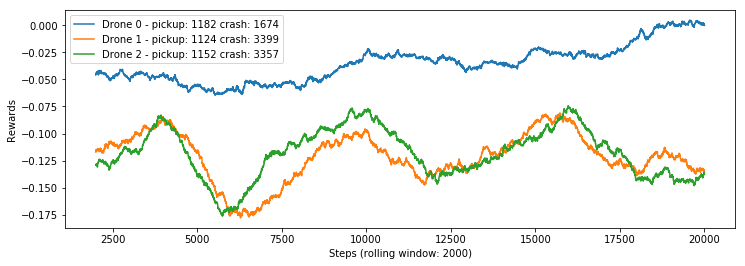

In [5]:
my_agent.is_greedy = False

# Train with different grids
for _ in range(10):
    trainer.train(2000) # Calls env.reset() -> new grid
    
    # Reset epsilon
    my_agent.epsilon_start *= 0.99
    my_agent.epsilon = my_agent.epsilon_start

plot_rolling_rewards(trainer.rewards_log, subset=range(0, 5))

Inspect agents
---

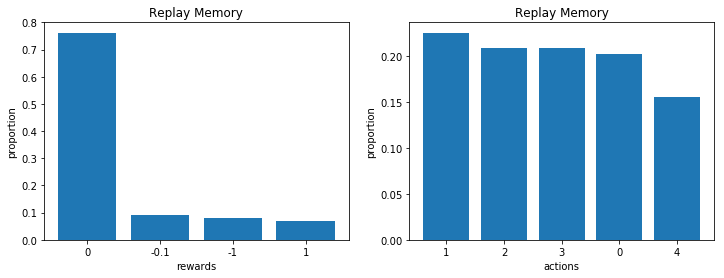

Top state:
 1) Count: 6 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0...
 2) Count: 4 state: [[[0. 0. 1. 0. 0. 0.]   [0. 0. 0. 0. 0. 0.]   [0. 0. 0. 0. 0. 0.]   [0. 0. 0. 0...
 3) Count: 4 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 1. 0...
 4) Count: 4 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0...
 5) Count: 4 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0...
 6) Count: 4 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0...
 7) Count: 3 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 1. 0...
 8) Count: 3 state: [[[0. 1. 0. 0. 0. 0.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 1. 0...
 9) Count: 3 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0...
10) Count: 3 state: [[[0. 0. 0. 0. 0. 1.]   [0. 0. 0. 0. 0. 1.

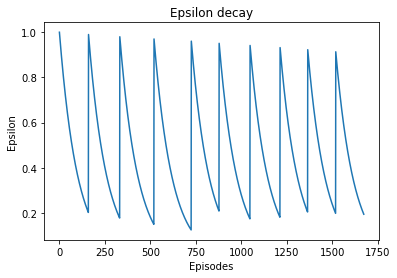

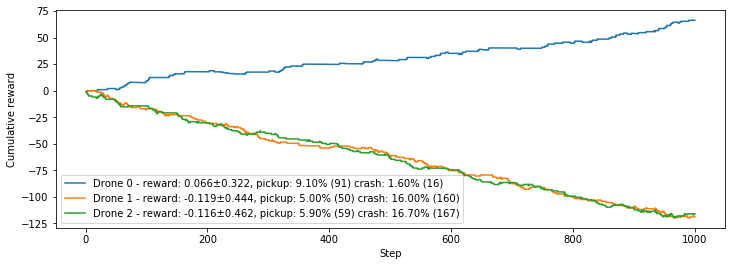

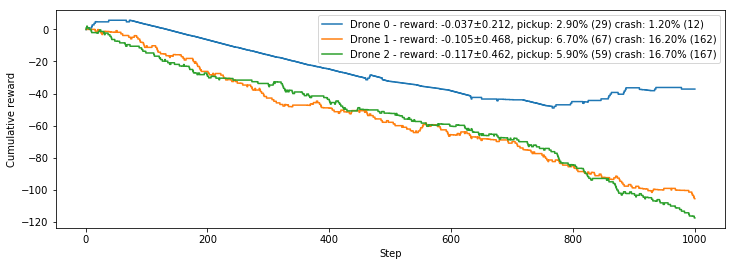

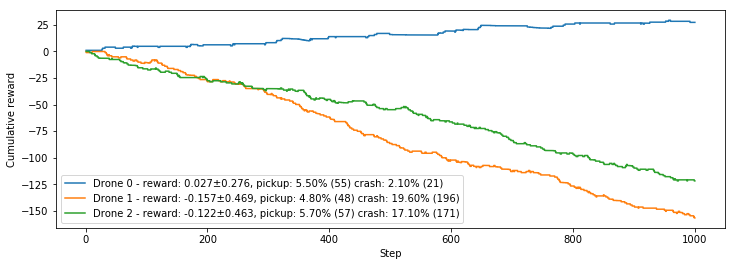

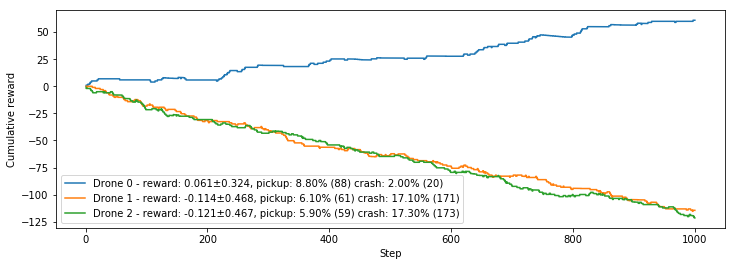

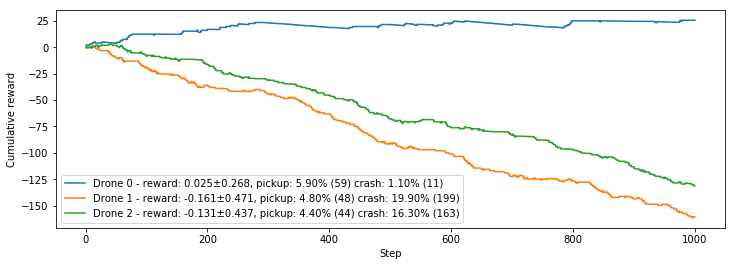

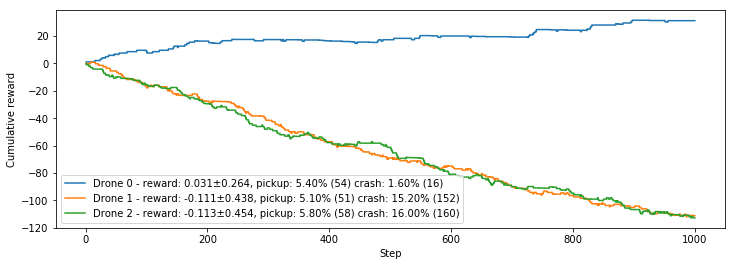

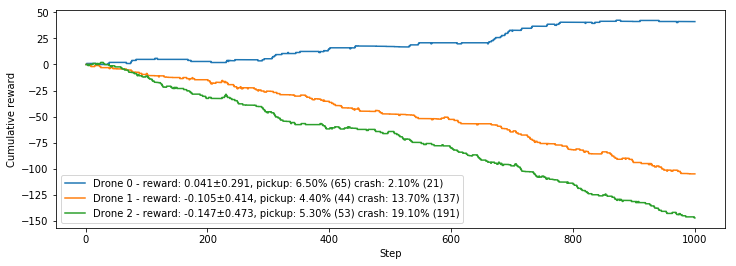

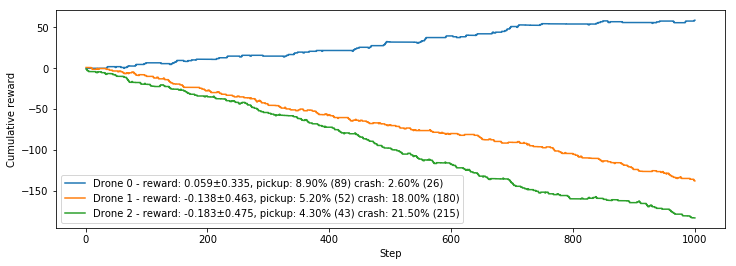

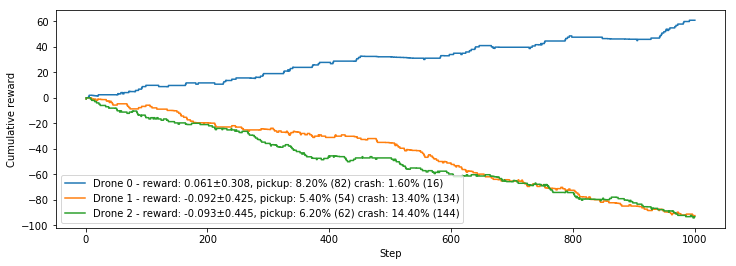

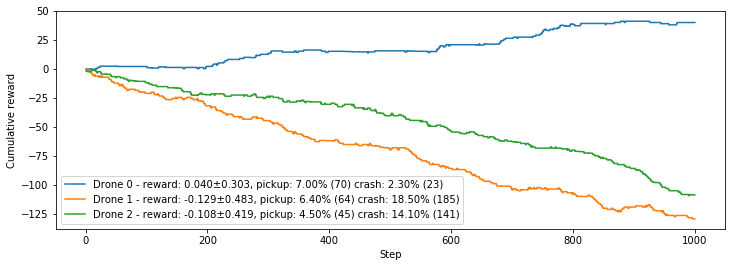

In [6]:
from IPython.display import display

# Q-learning agent
if isinstance(my_agent, QLearningAgent):
    # Q-table
    print('Q-table:', my_agent.get_qtable().shape)
    display(my_agent.get_qtable().sample(10))

# For DQN-agent
elif isinstance(my_agent, DQNAgent):
    # Memory replay
    my_agent.inspect_memory()
    
    # Q-network
    print('Q-network:')
    print(my_agent.qnetwork)
    print()
    
# Epsilon decay
plt.plot(my_agent.epsilons)
plt.title('Epsilon decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Test with different seeds
my_agent.is_greedy = True
for i in range(10):
    rewards_log = test_agents(env, agents, n_steps=1000, seed=i)
    plot_cumulative_rewards(rewards_log, subset=range(0, 5))

Test agents
---

In [7]:
from IPython.display import clear_output
import time

# Make sure our drone behaves greedily
my_agent.is_greedy = True

# Simulation loop
states = env.reset()
my_drone = env.drones[0]
rewards = None

while True:
    # Render
    clear_output(wait=True)
    print(env.render('ainsi'))

    # Act
    actions = {index: agent.act(states[index]) for index, agent in agents.items()}

    # Print last rewards and next actions
    print('Drone:', my_drone.index, 'charge: {}%'.format(my_drone.charge))
    if hasattr(env, 'format_state'):
        print('Current states:', env.format_state(states[my_drone.index]))
    if hasattr(env, 'format_action'):
        print('Next actions:', env.format_action(actions[my_drone.index]))
    if rewards is not None:
        print('Last rewards:', rewards[my_drone.index])

    # Sleep, step, learn
    time.sleep(1)
    states, rewards, dones, _ = env.step(actions)

+---+---+---+---+---+---+---+---+
|   |   |   | x |   | # | @ |   |
+---+---+---+---+---+---+---+---+
| 2 |   |[ ]| @ |   |   |   |[ ]|
+---+---+---+---+---+---+---+---+
|   | @ | # |   |   | x |   |   |
+---+---+---+---+---+---+---+---+
|   | x | # | # |   |   | # |   |
+---+---+---+---+---+---+---+---+
|[ ]|   | # | x | x |   |[ ]|   |
+---+---+---+---+---+---+---+---+
|   | 1 | x |   |   |   | @ |[ ]|
+---+---+---+---+---+---+---+---+
|[ ]| @ |   | # |   |   | x |0<x|
+---+---+---+---+---+---+---+---+
| # |   | @ | x |   | # |   |   |
+---+---+---+---+---+---+---+---+
Drone: 0 charge: 92%
Next actions: ←
Last rewards: 1


KeyboardInterrupt: 

Benchmarking
---

In [ ]:
%run env.py
%run rl-helpers.py

# Create drones & environment
env = WindowedGridView(DeliveryDrones(env_params={'n_drones': 10+1}), radius=3)
states = env.reset()

# Run drones
for i in tqdm(range(10**6)):
    states, rewards, dones, _  = env.step({drone.index: env.action_space.sample() for drone in env.drones})

Graphics
---

In [194]:
%matplotlib inline
from IPython.display import display
from PIL import Image
import numpy as np

In [211]:
colors = ['blue', 'green', 'red', 'yellow', 'pink']

# Load RGBA image
img = Image.open('16ShipCollection.png')
img_array = np.array(img)

# Make black background transparent
black_pixels = (img_array[:, :, 0] + img_array[:, :, 1] + img_array[:, :, 2]) == 0
img_array[np.nonzero(black_pixels) + (3,)] = 0

def get_ships_tile(row, col):
    tile_size, small_padding, big_padding = 16, 4, 10
    top_corner = (42, 28)
    
    i = top_corner[0] + row*(tile_size+small_padding)
    j = top_corner[1] + (col%5)*(tile_size+small_padding) + (col//5) * (5*(tile_size+small_padding) + big_padding)
    return Image.fromarray(img_array[i:i+tile_size, j:j+tile_size])

packet = get_ships_tile(12, 13)
dropzone = get_ships_tile(18, 24)
station = get_ships_tile(18, 15)
obstacle = get_ships_tile(11, 8)
wall = get_ships_tile(11, 8) # TODO: asteroid

display('packet', packet, 'dropzone', dropzone, 'station', station, 'obstacle', obstacle, 'wall', wall)

drone = get_ships_tile(1, 0) # TODO: drone iterator (rows: 0-10, 13, 15, 16, 17, columns: 0-4)
Image.alpha_composite(dropzone, drone)

'packet'

'dropzone'

'station'

'obstacle'

'wall'

```
-- combinations --
with_packet = red (col+10)
drone_charging = overlay + yellow (col+15)
drone_charging_with_packet = nothing
drone_over_dropzone = overlay

-- Nice to have: events --
just_delivered = drone + (.., ..)
just crashed = (.., ..) / drone + (.., ..) # debris?
```